In [1]:
from scipy.stats import levy_stable, norm
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [2]:
alpha, beta, gamma, delta = 1.7, .0, 1.0, 1.0

In [11]:
#10 1-day returns to 10-day return
def n_prod(a):
    prod = 1
    for i in range(len(a)):
        prod *= a[i] + 1
    return prod - 1

#calculating of quantile
def quantile(row, alpha):
    r = sorted(row)
    n = len(r)
    k = int(alpha * (n - 1))
    if k + 1 < alpha * n:
        return r[k + 1]
    elif k + 1 == alpha * n:
        return (r[k] + r[k + 1]) / 2
    else:
        return r[k]

#distribution 
def dist(row, function):
    min_val, max_val, size = min(row), max(row), len(row)
    step = (max_val - min_val) / size
    dist = np.zeros(size)
    for i in range(size):
        for r in row:
            if function == 'pdf':
                if r < min_val + step * (i + 1) and r >= min_val + step * i:
                    dist[i] += 1
            if function == 'cdf':
                if r < min_val + step * (i + 1):
                    dist[i] += 1
    return dist / size
    
#generating of percentile distribution    
def perc_distribution(perc = .01, n_trials = 1000, function = 'pdf'):
    samples = np.zeros(n_trials)
    for i in range(n_trials):
        ts_1 = levy_stable.rvs(alpha, beta, gamma, delta, size = 750)
        ts_10 = [n_prod(ts_1[i:i + 10]) for i in range(len(ts_1) - 10)]
        samples[i] = quantile(ts_10, perc)
    if function == ['cdf', 'pdf']:
        return np.sort(samples), dist(samples, 'cdf'), dist(samples, 'pdf')
    if function == 'pdf':
        return np.sort(samples), dist(samples, 'pdf')
    if function == 'cdf':
        return np.sort(samples), dist(samples, 'cdf')
    if function == 'samples':
        return np.sort(samples)
    
#confidence interval
def conf_interval(n, alpha):
    estimated_samples, estimated_freqs = perc_distribution(n_trials = n, function = 'pdf')
    estimated_exp = np.sum(estimated_samples * estimated_freqs)
    z_alpha = norm.ppf(1 - alpha/2)
    std = np.std(estimated_samples)
    left, right = estimated_exp - std * z_alpha / math.sqrt(n), estimated_exp + std * z_alpha / math.sqrt(n)
    return left, right

#fraction of occurrences
def interval_prob(left, rigth, samples):
    count = 0
    for sample in samples:
        if sample > left and sample < right:
            count += 1
    return count / samples.size

In [5]:
with open('test_output.txt', 'w') as output:
    t1 = time.time()
    left, right = conf_interval(50000, .05)
    t2 = time.time() - t1
    output.write('interval is counted, t = ' + str(t2 / 60) + '\n')
    n_trials = 10
    while(True):
        es = np.zeros(500)
        t1 = time.time()
        #500 expectations with current number of trials
        for i in range(500):
            samples, freqs = perc_distribution(n_trials = n_trials, function = 'pdf')
            e = np.sum(samples * freqs)
            es[i] = e
        p = interval_prob(left, right, es)
        t2 = time.time() - t1
        output.write('trials are counted ' + str(p) + ' t = ' + str(t2 / 60) + '\n')
        if n_trials > 50000:
            output.write('50000')
            break
        if p < 0.9:
            n_trials *= 2
        else:
            break

In [17]:
samples, cdf, pdf = perc_distribution(n_trials = 10240, function = ['cdf', 'pdf'])

In [26]:
log_samples = -np.log(-samples)

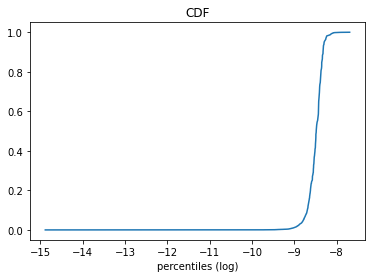

In [29]:
plt.plot(log_samples, cdf)
plt.title('CDF')
plt.xlabel('percentiles (log)')
plt.show()

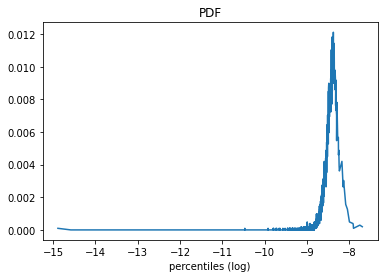

In [30]:
plt.plot(log_samples, pdf)
plt.title('PDF')
plt.xlabel('percentiles (log)')
plt.show()